# Identifying and characterizing calving and hydrology seismicity at Yahtse Glacier
Tim Bartholomaus -- for Glacier Seismology school -- June 13, 2017

This python-running Jupyter Notebook develops practical skills in manipulating and characterizing seismic data.  You will These exercises are framed around repeating some of the figures and analyses found in [Bartholomaus 2012](http://tbartholomaus.org/papers/Bartholomaus_etal_2012_JGR-ES.pdf) , [2015 JGR](http://tbartholomaus.org/papers/Bartholomaus_etal_2015_JGR-ES.pdf), and [2015 GRL](http://tbartholomaus.org/papers/Bartholomaus_etal_2015_GRL.pdf).

After clicking on a block of code here (known as a "cell"), you can run each cell, by pressing Shift + Enter (i.e., holding down the shift button, then pressing enter).

Here are some other useful keyboard shortcut:
Comment a line by adding a number sign (#) in front of it.
Block comment a set of selected lines with CNTRL + / in Windows, or CMD + / on a Mac.

In [1]:
# In python, sets of commands for special functions are grouped together and are imported as needed.
# These "packages" are analogous to the "toolboxes" in matlab.
import numpy as np                # numpy is used for numerical computing and with arrays
import matplotlib.pyplot as plt   # matplotlib and its pyplot sub-package is used for plotting
import obspy                      # obspy is for analyzing seismic data

#Set up pretty plotting
%matplotlib inline
plt.style.use('ggplot')#'seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 10, 5

The python package obspy is increasingly popular.  Below are the numbers of obspy citations each year.  The [obspy tutorial](http://docs.obspy.org/tutorial/) is a very useful place to learn what this mature but still rapidly improving package can do.
![Obspy citations](https://pbs.twimg.com/media/C7dKwQfXgAAr_e8.jpg:small "obspy google citations")


For this exercise, we'll be working with data from the Yahtse Glacier project, run from 2009 - 2011.  This data, like ~every NSF or NASA funded seismic deployment, is archived at the [IRIS Data Management Center (DMC)](http://ds.iris.edu/ds/nodes/dmc/data/).  One of the easiest tools for seismic data discovery is through a Google Map add-on.  You can see the map focused near the Yahtse Glacier network [here](http://ds.iris.edu/gmap/?minlat=60&maxlat=61&minlon=-143&maxlon=-140).  There's a nice guide using the map function [here](http://ds.iris.edu/gmap/help).  The short guidelines are simple: change the terms in the URL, and you can change what the map shows.

Using the IRIS [DMC's Google Map function](http://ds.iris.edu/gmap/?minlat=60&maxlat=61&minlon=-143&maxlon=-140), find the Yahtse Glacier network and note the two-character network code that organizes seismic data together.  We'll be working with data from station BOOM.

In [2]:
# ObsPy knows which website to connect to for many data center.
# For others you can also pass the full URL.
from obspy.clients.fdsn import Client
fdsn_client = Client("IRIS")

net_code = "XF" # Fill in the two-character network code for Yahtse Glacier here
sta_code = "BOOM"

If we can't end up accessing data from the FDSN servers, we can access miniseed data [here](https://vandalsuidaho-my.sharepoint.com/personal/tbartholomaus_uidaho_edu/_layouts/15/guestaccess.aspx?folderid=0e2c957be726c4dfebc07165e08b416c0&authkey=ATfKy4Z_U3L_QXhLhh9x908&expiration=2017-06-23T08%3a47%3a30.000Z)

these data can be read by typing: st = read('path_or_website_to_address/filename')

## Quickly reviewing data
An easy way to look at a lot of data quickly and simultaneously is through day plots, analogous to the old helicorder analog recorders from early seismic observatories.  Python makes these plots easy.

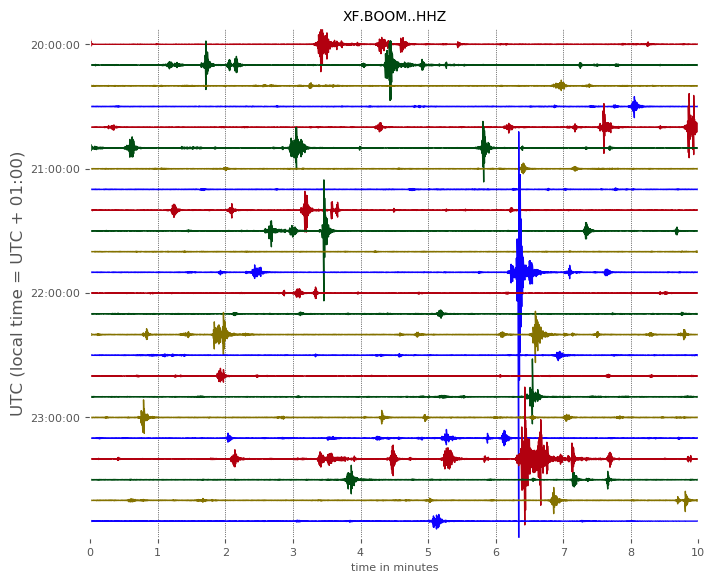

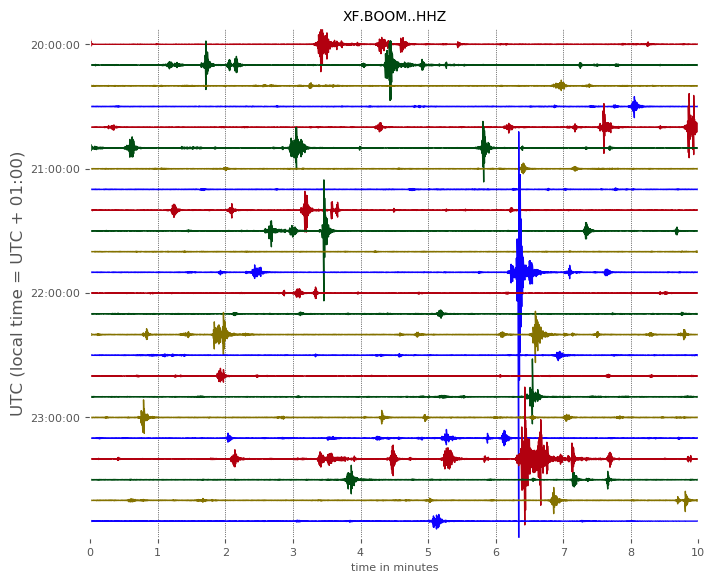

In [3]:
starttime = obspy.UTCDateTime(2010, 6, 11, 20, 0, 0)
endtime = obspy.UTCDateTime(2010, 6, 12, 0, 0, 0)

st = fdsn_client.get_waveforms(network=net_code, station=sta_code, location="", channel="HHZ",
                     starttime=starttime, endtime=endtime,
                     attach_response=True)
st = st.remove_response( output="VEL" ) # Magic function that does what Doug was looking for

st.slice(starttime=obspy.UTCDateTime(2010, 6, 11, 20, 0, 0),
    endtime=obspy.UTCDateTime(2010, 6, 12, 0, 0, 0)).filter(
    "bandpass", freqmin=1, freqmax=5).plot(type='dayplot', interval=10)

## Dominant frequencies of calving icequakes
One of the valuable ways in which we can discriminate amongst seismic signals is by examining spectra.  Below, create spectrograms of some calving icequakes from Yahtse Glacier in order to identify what the dominant frequencies are.

Create a spectrogram for the calving event, BOOM, as in Fig 5 of Bartholomaus et al., 2012.  In the cell below, define the UTCDateTime of the start and end of the data you would like to examine.  Use the start and end times from the paper and complete starttime and endtime as year, month, day, hr, min, sec.

What is dominant frequency of the energy release within this calving icequakes?  How does the frequency content of the icequake change over time?  Why might this pattern exist?


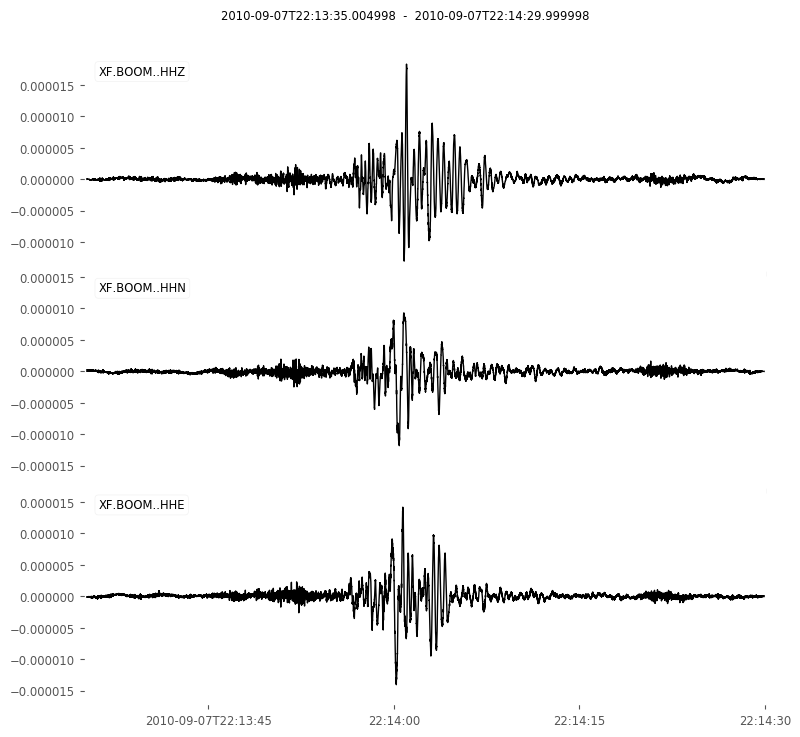

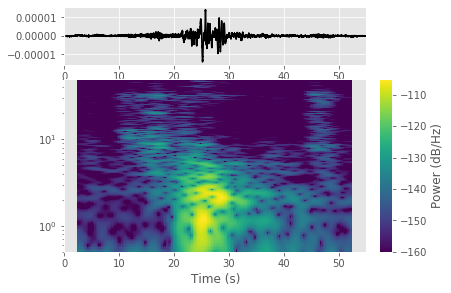

In [4]:

starttime = obspy.UTCDateTime(2010, 9, 7, 22, 13, 35) # <---- Set these time limits
endtime = obspy.UTCDateTime(2010, 9, 7, 22, 14, 30)

st = fdsn_client.get_waveforms(network=net_code, station=sta_code, location="", channel="HH*",
                     starttime=starttime, endtime=endtime,
                     attach_response=True)
sps = int(st[0].stats.sampling_rate)
st = st.remove_response( output="VEL" )

st.plot()

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

#make time vector
tr = st[0]
t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
ax1.plot(t, tr.copy().data, 'k')

tr.spectrogram(wlen=2*sps, per_lap=0.95,
    dbscale=True, log=True, axes=ax2)#, cmap='YlOrRd')
ax2.set_ylim((0.5,50))  # <---- Set these frequency limits
ax2.set_xlabel('Time (s)')

ax2.collections[0].set_clim(vmin=-160, vmax=-105) # Finds the quadmesh/pcolormesh created by the spectrogram call, and then change its clims
mappable = ax2.collections[0]
cb = plt.colorbar(mappable=mappable, cax=ax3, ticks=np.arange(-210,-100, 10))
cb.set_label('Power (dB/Hz)')

Create several hour-long spectrograms, similar to Fig 7 of Bartholomaus et al., 2012.  Examine data from September 2010.

What is the typical frequency content of the peak energy releases within these calving icequakes?

Check another hour in January 2011.  How are these spectrograms similar or different?



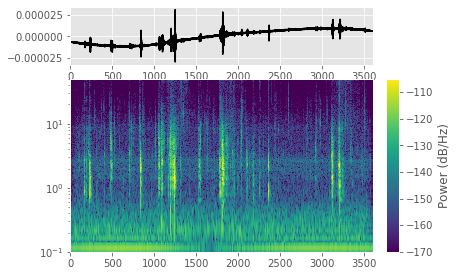

In [5]:

starttime = obspy.UTCDateTime(2010, 9, 7, 22, 0, 0) # <----- Modify these times
endtime = obspy.UTCDateTime(2010, 9, 7, 23, 0, 0)
#starttime = obspy.UTCDateTime(2010, 8, 7, 22, 0, 0)
#endtime = obspy.UTCDateTime(2010, 8, 7, 23, 0, 0)
#starttime = obspy.UTCDateTime(2011, 1, 7, 22, 0, 0)
#endtime = obspy.UTCDateTime(2011, 1, 7, 23, 0, 0)

st = fdsn_client.get_waveforms(network="XF", station="BOOM", location="", channel="HHZ",
                     starttime=starttime, endtime=endtime,
                     attach_response=True)
sps = int(st[0].stats.sampling_rate)
st = st.remove_response( output="VEL" )
tr = st[0]

fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

#make time vector
t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
ax1.plot(t, tr.copy().data, 'k')

tr.spectrogram(wlen=.1*sps, per_lap=0.90, dbscale=True,
    log=True, axes=ax2)#, cmap='YlOrRd')
ax2.set_ylim((0.1,50))

ax2.collections[0].set_clim(vmin=-170, vmax=-105) # Find the quadmesh/pcolormesh created by the spectrogram call, and then change its clims
mappable = ax2.collections[0]
cb = plt.colorbar(mappable=mappable, cax=ax3, ticks=np.arange(-210,-100, 10))
cb.set_label('Power (dB/Hz)')

## Characterizing the background noise
This next block of codes creates median spectrograms that better characterize background spectra, without the influence of brief transient events, like calving events.  The methods in this step are described in Bartholomaus et al., 2015, GRL.

How is this spectrogram similar or different from the figure above, which uses no statistical processing?

In [6]:
import get_med_spectra
from UTCDateTime_funcs import UTCfloor, UTCceil, UTC2dn # custom functions for working with obspy UTCDateTimes

station = 'BOOM'#TWLV'

# A set of parameters that define how the script will be run.
    # the coarse durations are the length of the windows from which multiple fine_duration PSDs will be averaged to produce a single median PSD
pp = {'coarse_duration': 600.0,  # s <---- Change these parameters to see how they affect the output
      'coarse_overlap' : 0.5,   # s
      'fine_duration'  : 20.0,   # s
      'fine_overlap'   : 0.5}   # s

t = np.arange( 0, tr.stats.npts/tr.stats.sampling_rate, pp['coarse_duration']*pp['coarse_overlap'])

Fs_old = 0 # initialize the sampling rate with zero, to ensure proper running in the first iteration

#%% Find the number of frequencies that the FFT will produce, and initialize the output array
L = int(tr.stats.sampling_rate) * pp['fine_duration']
freq_nums = int( 2**np.ceil(np.log2( L )) / 2 + 1 )#1025 #2049 # Number of frequencies output.  2049 for 200Hz data, 1025 for 100Hz data.
Pdb_array = np.ones( (freq_nums, len(t)) ) * -500.0 # initialize the final ar

for i in range(len(t)): # Loop over all the t's, however, the for loop will never complete

    tr_trim = tr.copy() # copy the trace in st

    # the minus small number and False nearest_sample make the tr include the first data point, but stop just shy of the last data point
    tr_trim.trim(tr.stats.starttime+t[i], tr.stats.starttime+t[i] + pp['coarse_duration'] - 0.00001, nearest_sample=False)

    # If you're at the end of the day volume, and the duration of tr_trim is not coarse_duration long:
    if tr.stats.starttime+t[i] + pp['coarse_duration'] > tr_trim.stats.endtime + 0.01:
        break

    freqs, Pdb, Fs_old = get_med_spectra.med_spec(tr_trim, pp, Fs_old)
    Pdb_array[:,i] = Pdb[:freq_nums] # Save the median spectra into an array

mask_val1 = Pdb_array<=-300
mask_val2 = np.isinf(Pdb_array)
Pdb_array_mask = np.ma.masked_where(np.any([mask_val1, mask_val2], axis=0), Pdb_array)

>>> Recalulating idx and WIND <<<


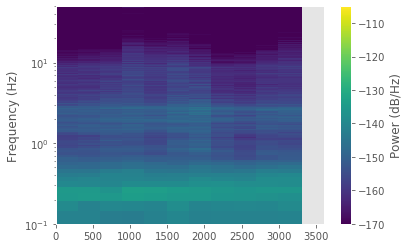

/Users/lion/miniconda3/envs/seismo_live/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0, 0.5, 'Power (dB/Hz)')

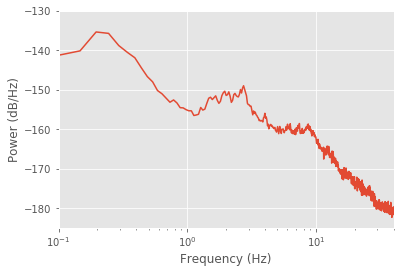

In [7]:
# These lines of code plot the median spectrogram

fig, ax = plt.subplots()#figsize=(8, 4))
qm = ax.pcolormesh(t, freqs, Pdb_array_mask, cmap='viridis')

ax.set_yscale('log')
plt.ylim([0.1, 50])
plt.xlim([0, t[-1]])
plt.ylabel('Frequency (Hz)')


qm.set_clim(vmin=-170, vmax=-105)#vmin=-210, vmax=-140)
cb = plt.colorbar(qm, ticks=np.arange(-210,-100, 10))
cb.set_label('Power (dB/Hz)')
plt.show()

# %%
plt.plot(freqs, np.median(Pdb_array_mask, axis=1))
plt.xscale('log')
plt.xlim([0.1, 40])
plt.ylim([-185, -130])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB/Hz)')

## Detection of calving icequakes
The simple STA/LTA (ratio of Short-Term-Average to Long-Term-Average) filter and similar filters are a popular, simple way to detect transient seismic events.  You can learn more about these detection tools and their parameters [here](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html).  First, chose the frequency bounds of typical calving icequakes, since we want to limit our assessment of the data to within these frequencies.  When exploring the choice of parameters, start with a short sample of the data (like 10 minutes), and adjust the parameters while re-running detector plots until you are happy with the output.  These parameters include the
* short term window length,
* long term window length,
* on threshold, and
* off thresholds.

When you've got a set of parameters that you like, change the time of inspected data broadly to different seasons and times of day.  Reassess your parameter choices.  To make this guess-and-check approach more rigorous, you might manually choose some set of training data and systematically explore the parameter space to identify those parameter values that best reproduce your manually-picked events.  However, in practice, this is often not done.  What _must_ be done is some verification that the results of your analysis are not overly sensitive to "reasonable" variations in parameter choices.

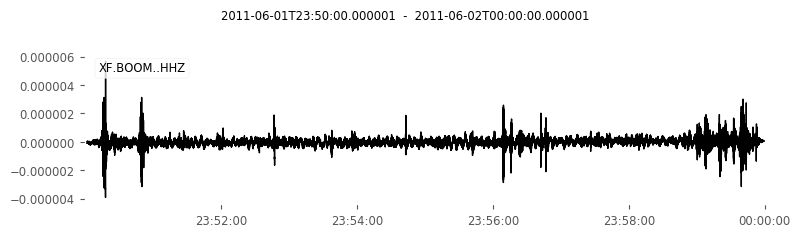

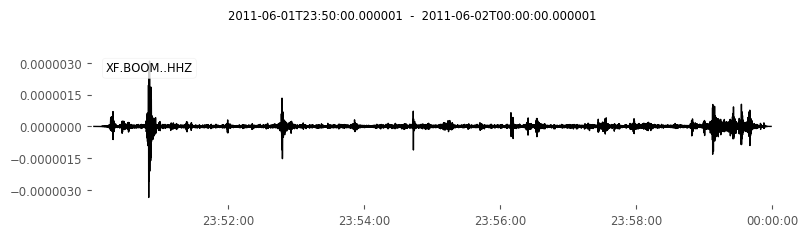

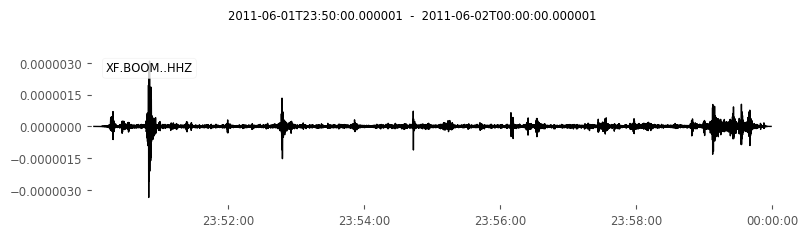

In [8]:
import obspy.signal.trigger as trg

freq_bounds = np.array([1, 5]) # <---- Set these frequency limits
        # low and high pass bounds for frequency filtering of data for detection analysis

starttime = obspy.UTCDateTime(2011, 6, 1, 23, 50, 0) # <---- Set the time period to examine
endtime = obspy.UTCDateTime(2011, 6, 2, 0, 0, 0)

st = fdsn_client.get_waveforms(network=net_code, station=sta_code, location="", channel="HHZ",
                     starttime=starttime, endtime=endtime,
                     attach_response=True)
st = st.remove_response( output="VEL" )

st[0].plot()

st[0].copy().taper(0.05).filter(
    "bandpass", freqmin=freq_bounds[0], freqmax=freq_bounds[1]).plot()

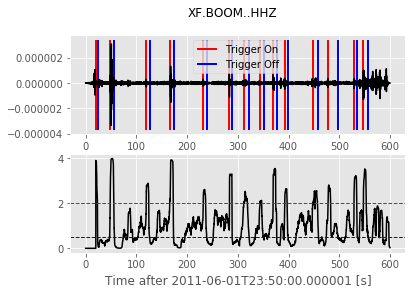

In [9]:

tr = st[0].filter(
    "bandpass", freqmin=freq_bounds[0], freqmax=freq_bounds[1])
sps = int(tr.stats.sampling_rate)

onthresh = 2.0
offthresh = 0.5
shortwin = 5 # sec
longwin = 20 # sec
cft = trg.classic_sta_lta(tr.data, shortwin * sps, longwin * sps)
trg.plot_trigger(tr, cft, onthresh, offthresh)

In multiple studies (Qamar, 1988; O'Neel, 2007; Bartholomaus, 2015; Kohler 2016), the duration of calving icequakes  has been shown to be an important predictor of iceberg size and/or calving flux.  Below, calculate and record the cumulative duration of calving events on randomly selected days during the Yahtse seismic experiment.  I recommend choosing some fixed amount of time on the first of each month.  Choose the longest fixed amount of time that you can bear to wait for the data to be retrieved and the analysis to run.  I recommend trying 12 hrs on the first of each month.

In [10]:
trigs = trg.trigger_onset(cft, onthresh, offthresh) # the array of trigger on and off indices

event_times = np.array(starttime) + trigs/sps # Detection "on" times

# del durs # remove the durs variable, so that old time runs don't contaminate new runs.
durs = np.diff(trigs, axis=1)/sps # s  duration of events
durs = durs[:,0]

print(starttime)
print( int(sum(durs)) )

#det_times = np.concatenate((det_times, event_times), axis=0)
#det_durs = np.concatenate((det_durs, durs), axis=0)

2011-06-01T23:50:00.000000Z
116


In [11]:
time_xlabels = np.array(
                    ['6/10', '7/10', '8/10', '9/10', '10/10', '11/10', '12/10', '1/11', '2/11', '3/11', '4/11', '5/11', '6/11', '7/11', '8/11'])
# Copy the cumulative durations here:
# XXX: This should be filled in.
# cum_durs = np.array([ ,   ,  ,  ,   ,   ,   ,  ,   ,  ,  ,  ])

# fig, ax = plt.subplots()
# ax.plot(np.arange(0, len(cum_durs)), cum_durs)
# ax.set_xticks(np.arange(0, len(cum_durs), 2)) # Create ticks at every other value
# ax.set_xticklabels(time_xlabels[::2]) # Label the ticks with every other cum_durs